In [ ]:
!python -m pip install antspynet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


In [ ]:
import ants
import antspynet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.6 MB/s eta 0:00:00
Loading T1 image...


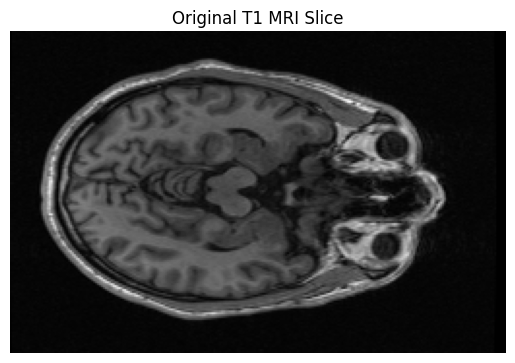

Applying N4 bias field correction...


In [ ]:
# Libraries Installation
!pip install nibabel nilearn nipype antspyx

# Import Libraries
import nibabel as nib
import ants
import numpy as np
import matplotlib.pyplot as plt

# Data Path
t1_path = '/content/drive/MyDrive/ADNI_BASE_NIfTI/002_S_1155/002_S_1155.nii.gz'  # مسیر فایل را تنظیم کنید

# Loading Image
print("Loading T1 image...")
t1_image = nib.load(t1_path)
t1_data = t1_image.get_fdata()

# Plotting one slide of T1 image
plt.imshow(t1_data[:, :, t1_data.shape[2] // 2], cmap="gray")
plt.title("Original T1 MRI Slice")
plt.axis("off")
plt.show()

# --- A. Bias Field Correction (N4ITK) ---
print("Applying N4 bias field correction...")
t1_ants = ants.image_read(t1_path)
t1_corrected = ants.n4_bias_field_correction(t1_ants)

# Save after Bias Correction
bias_corrected_path = '/content/t1_corrected.nii.gz'
ants.image_write(t1_corrected, bias_corrected_path)

# Show Image after Bias Correction
plt.imshow(t1_corrected.numpy()[:, :, t1_corrected.shape[2] // 2], cmap="gray")
plt.title("Bias Corrected T1 MRI Slice")
plt.axis("off")
plt.show()

# --- B. Skull Stripping ---
print("Performing skull stripping...")
# ANTs-flavored
seg = antspynet.brain_extraction(t1_corrected, modality="t1", verbose=True)
t1_skull_stripped = t1_corrected * seg
#ants.plot(t1, overlay=seg, overlay_alpha=0.5)


# Save after Skull Stripping
skull_stripped_path = '/content/t1_skull_stripped.nii.gz'
ants.image_write(t1_skull_stripped, skull_stripped_path)

# Show image after Skull Stripping
plt.imshow(t1_skull_stripped.numpy()[:, :, t1_skull_stripped.shape[2] // 2], cmap="gray")
plt.title("Skull Stripped T1 MRI Slice")
plt.axis("off")
plt.show()

# --- C. Registration to MNI Space ---
print("Registering to MNI space...")
template = ants.image_read(ants.get_ants_data("mni"))
reg = ants.registration(fixed=template, moving=t1_skull_stripped, type_of_transform="Affine")

# Save
registered_path = '/content/t1_registered.nii.gz'
ants.image_write(reg['warpedmovout'], registered_path)

# Show
plt.imshow(reg['warpedmovout'].numpy()[:, :, reg['warpedmovout'].shape[2] // 2], cmap="gray")
plt.title("Registered T1 MRI Slice")
plt.axis("off")
plt.show()

# --- D. Normalization ---
print("Normalizing intensities...")
t1_normalized_data = (reg['warpedmovout'].numpy() - np.min(reg['warpedmovout'].numpy())) / (
    np.max(reg['warpedmovout'].numpy()) - np.min(reg['warpedmovout'].numpy())
)

# Save
normalized_path = '/content/t1_normalized.nii.gz'
nib.save(nib.Nifti1Image(t1_normalized_data, affine=t1_image.affine), normalized_path)

# Show
plt.imshow(t1_normalized_data[:, :, t1_normalized_data.shape[2] // 2], cmap="gray")
plt.title("Normalized T1 MRI Slice")
plt.axis("off")
plt.show()


from google.colab import drive
drive.mount('/content/drive')

!cp {bias_corrected_path} /content/drive/MyDrive/
!cp {skull_stripped_path} /content/drive/MyDrive/
!cp {registered_path} /content/drive/MyDrive/
!cp {normalized_path} /content/drive/MyDrive/

print("All preprocessed images have been saved!")

In [ ]:
# Install all necessery libraries
!pip install nibabel nilearn nipype antspyx

# Import Libraries
import os
import nibabel as nib
import ants
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# --- Mount Google Drive ---
#drive.mount('/content/drive')

# Data Path
base_input_path = '/content/drive/MyDrive/ADNI_BASE_NIfTI'
base_output_path = '/content/drive/MyDrive/ADNI_Preprocessed'

# Create output folder (if it doesn't exist)
os.makedirs(base_output_path, exist_ok=True)
n = 0
# Find all .nii.gz files
for root, dirs, files in os.walk(base_input_path):
    for file in files:
        if file.endswith('.nii.gz'):
            # Data Path
            t1_path = os.path.join(root, file)
            print(f"Processing file: {t1_path}")
            t1_image = nib.load(t1_path)
            t1_data = t1_image.get_fdata()

            # Loading Images
            t1_ants = ants.image_read(t1_path)

            # --- A. Bias Field Correction ---
            print("Applying N4 bias field correction...")
            t1_corrected = ants.n4_bias_field_correction(t1_ants)

            # --- B. Skull Stripping ---
            print("Performing skull stripping...")
            seg = antspynet.brain_extraction(t1_corrected, modality="t1", verbose=True)
            t1_skull_stripped = t1_corrected * seg

            # --- C. Registration to MNI Space ---
            print("Registering to MNI space...")
            template = ants.image_read(ants.get_ants_data("mni"))
            reg = ants.registration(fixed=template, moving=t1_skull_stripped, type_of_transform="Affine")

            # --- D. Normalization ---
            print("Normalizing intensities...")
            t1_normalized_data = (reg['warpedmovout'].numpy() - np.min(reg['warpedmovout'].numpy())) / (
                np.max(reg['warpedmovout'].numpy()) - np.min(reg['warpedmovout'].numpy())
            )
            n = n + 1
            print(n)
            # ذخیره تصویر نرمال شده
            output_file_name = file.replace('.nii.gz', '_preprocessed.nii.gz')
            output_file_path = os.path.join(base_output_path, output_file_name)
            nib.save(nib.Nifti1Image(t1_normalized_data, affine=t1_image.affine), output_file_path)
            #nib.save(nib.Nifti1Image(t1_normalized_data, affine=t1_image.affine), normalized_path)

            print(f"Saved preprocessed file to: {output_file_path}")

print("All files have been processed and saved!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 102.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.3 MB/s eta 0:00:00
Processing file: /content/drive/MyDrive/ADNI_BASE_NIfTI/002_S_4229/002_S_4229.nii.gz
Applying N4 bias field correction...
Performing skull stripping...
Brain extraction:  retrieving model weights.
5683832/5683832 [

1/1 [==============================] - 10s 10s/step
Brain extraction:  renormalize probability mask to native space.
Registering to MNI space...
Normalizing intensities...
5
Saved preprocessed file to: /content/drive/MyDrive/ADNI_Preprocessed/002_S_4237_preprocessed.nii.gz
Processing file: /content/drive/MyDrive/ADNI_BASE_NIfTI/002_S_2043/002_S_2043.nii.gz
Applying N4 bias field correction...
Performing skull stripping...
Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.


1/1 [==============================] - 10s 10s/step
Brain extraction:  renormalize probability mask to native space.
Registering to MNI space...
Normalizing intensities...
6
Saved preprocessed file to: /content/drive/MyDrive/ADNI_Preprocessed/002_S_2043_preprocessed.nii.gz
Processing file: /content/drive/MyDrive/ADNI_BASE_NIfTI/002_S_4654/002_S_4654.nii.gz
Applying N4 bias field correction...
Performing skull stripping...
Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 [==============================] - 10s 10s/step
Brain extraction:  renormalize probability mask to native space.
Registering to MNI space...
Normalizing intensities...
7
Saved preprocessed file to: /content/drive/MyDrive/ADNI_Preprocessed/002_S_4654_preprocessed.nii.gz
Processing file: /content/drive/MyDrive/ADNI_BASE_NIfTI/002_S_4473/002_S_4473.nii.gz
Applying N4 bias field correctio

In [ ]:
!pip install nibabel nilearn nipype antspyx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00


In [ ]:
# Import Libraries
import os
import nibabel as nib
import ants
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# --- Mount Google Drive ---
#drive.mount('/content/drive')

# Data path
input_folder = '/content/drive/MyDrive/ADNI_BASE_NIfTI'
output_folder = '/content/drive/MyDrive/ADNI_Preprocessed'

# Create output folder if it does not exist
os.makedirs(output_folder, exist_ok=True)

# Get the list of processed files
processed_files = [f.replace("_preprocessed.nii.gz", "") for f in os.listdir(output_folder) if f.endswith("_preprocessed.nii.gz")]
print(processed_files)
# Get the list of files in the input folder
input_files = []

for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.endswith('.nii.gz'):
            input_files.append(file)

print(input_files)
S = 0
# Process files that have not been processed
for root, dirs, files in os.walk(input_folder):
    for file in files:
        if file.endswith('.nii.gz') and file.replace(".nii.gz", "") in processed_files :
            #file = file.replace(".nii.gz","") # حذف پسوند فایل
            #if file.replace(".nii.gz", "") in processed_files:
          print(f"Skipping already processed file: {file}")
          S = S + 1
          print(S)
          continue
        if file.endswith('.nii.gz'):
          t1_path = os.path.join(root, file)
          print(f"Processing file: {t1_path}")
          t1_image = nib.load(t1_path)
          t1_data = t1_image.get_fdata()

            # Loading Image
          t1_ants = ants.image_read(t1_path)

            # --- A. Bias Field Correction ---
          print("Applying N4 bias field correction...")
          t1_corrected = ants.n4_bias_field_correction(t1_ants)

            # --- B. Skull Stripping ---
          print("Performing skull stripping...")
          seg = antspynet.brain_extraction(t1_corrected, modality="t1", verbose=True)
          t1_skull_stripped = t1_corrected * seg

            # --- C. Registration to MNI Space ---
          print("Registering to MNI space...")
          template = ants.image_read(ants.get_ants_data("mni"))
          reg = ants.registration(fixed=template, moving=t1_skull_stripped, type_of_transform="Affine")

            # --- D. Normalization ---
          print("Normalizing intensities...")
          t1_normalized_data = (reg['warpedmovout'].numpy() - np.min(reg['warpedmovout'].numpy())) / (np.max(reg['warpedmovout'].numpy()) - np.min(reg['warpedmovout'].numpy()))
          S = S + 1
          print(S)
            # Save the normalized image
          output_file_name = file.replace('.nii.gz', '_preprocessed.nii.gz')
          output_file_path = os.path.join(output_folder, output_file_name)
          nib.save(nib.Nifti1Image(t1_normalized_data, affine=t1_image.affine), output_file_path)
          #nib.save(nib.Nifti1Image(t1_normalized_data, affine=t1_image.affine), normalized_path)

          print(f"Saved preprocessed file to: {output_file_path}")

print("All files have been processed and saved!")


['002_S_4229', '002_S_4171', '002_S_4521', '002_S_4219', '002_S_4237', '002_S_2043', '002_S_4654', '002_S_4473', '002_S_1155', '002_S_4447', '006_S_4515', '009_S_1030', '005_S_0546', '007_S_6341', '006_S_4679', '003_S_1122', '006_S_4346', '003_S_4354', '006_S_4363', '003_S_0908', '011_S_1080', '009_S_4903', '009_S_4958', '009_S_4814', '009_S_4530', '009_S_2381', '009_S_5000', '009_S_4324', '011_S_4235', '009_S_2208', '012_S_4012', '012_S_4128', '012_S_4987', '011_S_4893', '013_S_1186', '012_S_4849', '013_S_2324', '011_S_4366', '012_S_4094', '012_S_4188', '014_S_4263', '013_S_4985', '014_S_4079', '014_S_4328', '014_S_0169', '014_S_2308', '013_S_4791', '013_S_4595', '013_S_4917', '014_S_4058', '018_S_4868', '016_S_1117', '018_S_4889', '014_S_4668', '018_S_4809', '018_S_0142', '018_S_2155', '018_S_4597', '019_S_4285', '019_S_4548', '019_S_4680', '022_S_2087', '022_S_4805', '020_S_4920', '022_S_1097', '023_S_0376', '022_S_5004', '022_S_2167', '023_S_1046', '023_S_2068', '023_S_4241', '023_

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Brain extraction:  renormalize probability mask to native space.
Registering to MNI space...
Normalizing intensities...
300
Saved preprocessed file to: /content/drive/MyDrive/ADNI_Preprocessed/137_S_4536_preprocessed.nii.gz
Processing file: /content/drive/MyDrive/ADNI_BASE_NIfTI/153_S_2148/153_S_2148.nii.gz
Applying N4 bias field correction...
Performing skull stripping...
Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.


1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
Brain extraction:  renormalize probability mask to native space.
Registering to MNI space...
Normalizing intensities...
301
Saved preprocessed file to: /content/drive/MyDrive/ADNI_Preprocessed/153_S_2148_preprocessed.nii.gz
Processing file: /content/drive/MyDrive/ADNI_BASE_NIfTI/141_S_1255/141_S_1255.nii.gz
Applying N4 bias field correction...
Performing skull stripping...
Brain extraction:  retrieving model weights.
Brain extraction:  retrieving template.
Brain extraction:  normalizing image to the template.
Brain extraction:  prediction and decoding.
1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step
Brain extraction:  renormalize probability mask to native space.
Registering to MNI space...
Normalizing intensities...
302
Saved preprocessed file to: /content/drive/MyDrive/ADNI_Preprocessed/141_S_1255_preprocessed.nii.gz
Processing file: /content/drive/MyDrive/ADNI_BASE_NIfTI/141_S_4438/141_S_4438.nii.gz
Applying N4 bias field correction...
Performing skull st